In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2 as cv
from scipy import spatial

from scipy.signal import find_peaks
from scipy.optimize import curve_fit


# import matplotlib
# matplotlib.use("nbagg")

Assume that the background noise is the same throughout the image, and the vertical line has an angle of 0° (which, on 
closer inspection, is the case). 

Explain why no threshold

ADD x y LABELS!

In [2]:
def read_image(file_path, roi=None):
    """
    Read an image from a file and crop it to a region of interest (ROI).

    PARAMETERS:
        file_path (str): The path to the image file.
        roi (list): A list of four integers [x1, x2, y1, y2], specifying the 
            region of interest (default: None).

    RETURNS:
        array: The cropped image.
    """

    # Read the image
    image = cv.imread(file_path, 0)

    # Crop the image to the region of interest
    if roi is not None:
        image = image[roi[2]:roi[3], roi[0]:roi[1]]

    return image
    

def read_image_series(directory, prefix=None, roi=None):
    """
    Read a series of images from a directory and crop them to a region of interest (ROI).
    
    PARAMETERS:
        directory (str): The path to the directory containing the images.
        prefix (str): A common prefix for the image files (default: None).
        roi (list): A list of four integers [x1, x2, z1, z2], specifying the 
            region of interest (default: None).
            
    RETURNS:
        list: A list of cropped images.
    """
    
    # Get a list of all files in the directory
    files = os.listdir(directory)
    
    # If a prefix is specified, filter the list of files
    if prefix is not None:
        files = [f for f in files if f.startswith(prefix)]
        
    # Sort the list of files
    files.sort()
    
    # Read the images and store them in a list
    images = [read_image(os.path.join(directory, f), roi) for f in files]
    
    return images

In [3]:
def all_distances(x, y=None):
    """Calculate the distance between all points in a 2D (x,y) space

    PARAMETERS:
        x (np.array): The x-coordinates of the points
        y (np.array): The y-coordinates of the points

    RETURNS:
        distances_px (np.array): The distances between all points
    """
    
    # If only one array is given, assume the other one contains only zeros
    if y is None:
        y = np.zeros_like(x)
    
    # Combine the x and y coordinates into a single array
    xy = np.column_stack([x, y])

    # Calculate the distance between all points
    distances = spatial.distance.cdist(xy, xy, 'euclidean')

    return distances

In [4]:
def weighted_avg_and_std(values, weights, mask_diagonal=True,
                         verbose=False, precision=6, units="mm/px"):
    """
    Calculate the weighted average and standard deviation of a set of values.

    PARAMETERS:
        values (array-like): The values for which to calculate the weighted 
            average and standard deviation.
        weights (array-like): The weights corresponding to each value.
        mask_diagonal (bool): Whether to mask the diagonal of the
            distance matrix (default: True).
        verbose (bool): Whether to print the results (default: False).
        precision (int): The number of decimal places to round the results 
            to (default: 5).
        units (str): The units of the values (default: "mm/px").

    RETURNS:
        tuple: A tuple containing the weighted average and standard deviation.
    """

    # Mask the diagonal to avoid division by zero
    if mask_diagonal:
        mask = np.eye(values.shape[0], dtype=bool).__invert__()

    # Calculate the weighted average
    average = np.average(values[mask], weights=weights[mask])

    # Calculate the weighted variance and standard deviation
    variance = np.average((values[mask] - average) ** 2, weights=weights[mask])
    deviation = np.sqrt(variance)
    
    if verbose:
        print(f"The average resolution is {average:.{precision}f} {units},")
        print(f"with a standard deviation of {np.sqrt(variance):.{precision}f}"
              f" {units} ({100 * deviation / average:.{precision-2}} %).")

    # Output the average and standard deviation
    return average, deviation

In [5]:
def intensity_peaks(profile, method='weighted_avg', threshold=85):
    """
    Find the peaks in an intensity profile.
    
    PARAMETERS:
        profile (array-like): The intensity profile.
        method (str): The method to use for peak detection (default: 'weighted_avg').
        threshold (float): The threshold for peak detection (default: 85).
        
    RETURNS:
        array: The indices of the peaks in the profile.
    """
    
    # METHOD #1: WEIGHTED INTENSITY AVERAGE
    if method == 'weighted_avg':

        # For each z coordinate...
        peak_indices = []; peak_intensities = []; current_group = []
        for idx in range(len(profile)):
            
            # Check whether the current row is above the threshold
            if profile[idx] > threshold:
                
                # If so, append the row number to the list of peak indices
                current_group.append(idx)
            else:
                
                # If not, check whether this is the end of a peak
                if len(current_group) > 0:
                    # Calculate the average intensity
                    peak_intensities.append(np.mean(profile[current_group]))
                    
                    # Calculate an average peak coordinate, weighed by the intensity 
                    peak_indices.append(
                            np.dot(profile[current_group], current_group) / 
                            np.sum(profile[current_group]))
                    
                    # Reset the current peak group
                    current_group = []
                    
    # Throw error if wrong method is specified
    else:
        raise ValueError(f"Unknown method '{method}'")
    
    # Return the (subpixel precision) indices of the peaks and their intensities
    return peak_indices, peak_intensities

In [21]:
def calibrate_camera(image, calib_dist, threshold, units="mm/px", plot=False, 
                     verbose=False, precision=3):
    
    
    # Average all pixels in the x-direction to get the intensity profile
    int_profile = np.mean(image, axis=1)
    
    # Calculate the peaks in the intensity profile
    peak_px, peak_intensities = intensity_peaks(int_profile, 
                                                    threshold=threshold)

    # Calculate the distances between all peaks
    dist_px = all_distances(peak_px)
    
    # Define an array of distances in real units and calculate all distances
    peak_re = calib_dist * np.arange(0, len(peak_px))
    dist_re = all_distances(peak_re)
    
    # Ignoring division by zero... 
    with np.errstate(divide='ignore', invalid='ignore'):
        # ...calculate the resolutions of the image in units length per pixel
        res_matrix = dist_re / dist_px
        
    # Calculate the weighted average and standard deviation of the resolutions
    res_avg, res_std = weighted_avg_and_std(res_matrix, dist_px, 
                                            verbose=verbose, 
                                            precision=precision)

    # Plot the cropped image and intensity profile side-by-side
    if plot:
        _, ax = plt.subplots(1, 2, figsize=(8, 10))
        
        # Plot the cropped image
        ax[0].imshow(image, cmap='gray')
        ax[0].set_title('Cropped calibration image')
        ax[0].set_xlabel('x [px]'); ax[0].set_ylabel('z [px]')
        
        # Plot the intensity profile
        ax[1].plot(int_profile, np.arange(0, len(int_profile)), '.')
        ax[1].set_title('Intensity profile')
        ax[1].set_xlabel('|I| (a.u.)'); ax[1].set_ylabel('z [px]')
        
        # Add a vertical line for the threshold
        ax[1].axvline(threshold, color='r', linestyle='--')
        
        # Flip and scale the profile axis to match the image
        ax[1].invert_yaxis()
        ax[1].set_ylim([len(int_profile), 0])
        plt.show()
        
    return res_avg, res_std

In [7]:
def calibrate_cameras(directory, roi, threshold, 
                      plot=False, prefix='Calibration'):
    """
    
    """

    # Read the calibration images in grayscale [z, x]
    calib_images = read_image_series(directory, prefix=prefix, roi=roi)
    
    # For each calibration image...
    for calib_image in calib_images:
        
        calibrate_camera(calib_image, threshold, plot=plot)

The average resolution is 4.889 mm/px,
with a standard deviation of 0.002 mm/px (0.03 %).


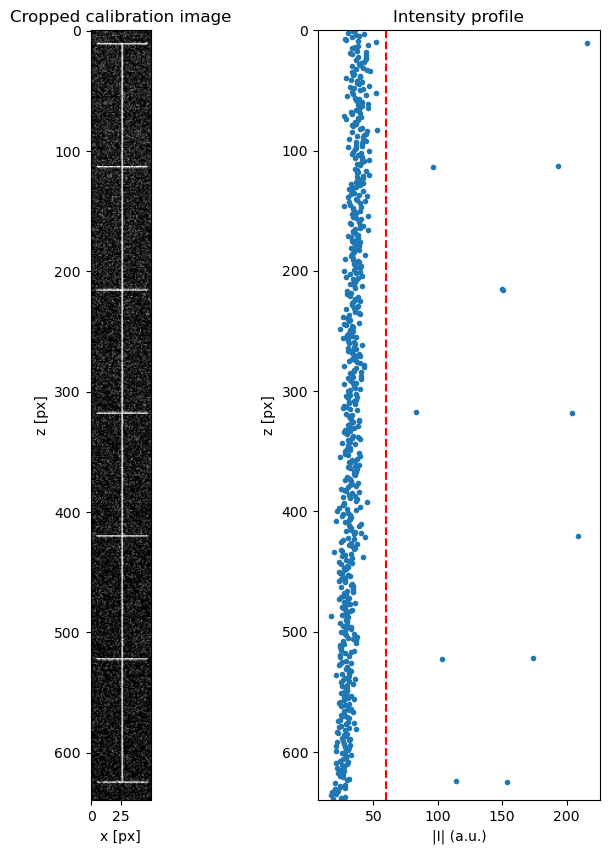

(4.889463462087954, 0.0016792371367638616)

In [24]:
calib_images = read_image_series('PTV', prefix='Calibration_b',
                                 roi=[200, 250, 30, 670])

calibrate_camera(calib_images[0], 500, 60, plot=True, verbose=True)


Pixel centres do not matter, is just half a pixel offset.

We kunnen nog Gaussians fitten!